## Prioritized Experience Replay
In the original DQN paper (and implementation), random transitions were sampled uniformly from the replay buffer and used for learning. Naturally the next question to ask is, "can we sample some other way and expect better performance?" That is, can we learn more from some transitions than from others? To draw a parallel, envision some task you're accustomed to performing with an expected outcome. If someday you perform this same task but achieve some wildly different outcome, you'd stop to reevaluate the situation. You'd think long and hard trying to come up with an explanation (adjusting your model) for this unexpected event. This is same idea behind prioritized experience replay. We assign some priority to transitions and when it's time to sample, we choose the transitions with the highest priorities because we expect to learn more from them.

In [1], the TD error, $\delta_i$, of a transition is used to compute its priority. The authors stated that it "indicates how surprising or unexpected the transition is." Two methods for assigning priority are given:

Proportional Prioritization: $p_i = |\delta_i| + \epsilon$

Rank Prioritization: $p_i = \frac{1}{rank(i)}$

where $\delta_i$ is the TD error, $\epsilon$ is a small constant and rank(i) is the rank of transition i when the replay buffer is sorted according to $|\delta_i|$

For rank proritization, a priority queue can be used. For proportional prioritization, the authors have used the sum tree data structure with the property that the value of all internal nodes are the sum of their respective children. Thus, the root node's value is the sum of all leaf nodes. See sumtree.ipynb for an understanding of how the sum tree works. Below I compare the performance of an agent on the CartPole problem using uniform sampling and with prioritized sampling.

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import cntk
from cntk.layers import *
from sumtree import SumTree
%matplotlib inline

In [2]:
class UniformBuffer: 
    """
    Fixed capacity buffer implemented as circular queue
    Transitions are stored as (s, a, r, s', done) tuples
    """
    def __init__(self, capacity):
        self.samples = np.ndarray(capacity, dtype=object)
        self.capacity = capacity
        self.counter = 0
        self.flag = False
        
    def size(self):
        if self.flag:
            return self.capacity
        else:
            return self.counter
        
    def add(self, sample):
        self.samples[self.counter] = sample
        
        self.counter += 1
        if self.counter >= self.capacity:
            self.counter = 0
            self.flag = True
            
    def sample(self, n):
        n = min(n, self.size())
        
        size = self.size()
        if size < self.capacity:
            return np.random.choice(self.samples[:size], n, replace=False)
        else:
            return np.random.choice(self.samples, n, replace=False)

In [3]:
class PrioritizedBuffer:
    """
    Stores transitions as (s, a, r, s_, done) tuples using a SumTree.
    Each sample is assigned a priority which affects retrieval
    """

    def __init__(self, capacity, e=0.01, a=0.6):
        """        
        :param capacity: The maximum number of samples that can be stored
        :param e: Ensures that no sample has 0 priority
        :param a: 
        """
        self.capacity = capacity
        self.e = e
        self.a = a
        self.counter = 0
        self.flag = False

        self.tree = SumTree(capacity)
        
    def size(self):
        if self.flag:
            return self.capacity
        else:
            return self.counter

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        """
        Adds a new sample to the buffer
        :param error: The error associated with the sample
        :param sample: The sample to add 
        """
        p = self._getPriority(error)
        self.tree.add(p, sample)
        
        self.counter += 1
        if self.counter >= self.capacity:
            self.counter = 0
            self.flag = True    

    def sample(self, n):
        """
        Returns n samples from the buffer
        :param n: The number of samples to return
        """
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append((idx, data))

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [4]:
class Agent:
    def __init__(self, state_dim, action_dim, learning_rate):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.epsilon = 1
        
        # Create the model and set up trainer
        self.state_var = input(self.state_dim, np.float32)
        self.action_var = input(self.action_dim, np.float32)
        
        self.online_model = Sequential([
            Dense(64, activation=cntk.relu),
            Dense(self.action_dim)
        ])(self.state_var)

        loss = cntk.reduce_mean(cntk.square(self.online_model - self.action_var), axis=0)
        lr_schedule = cntk.learning_rate_schedule(self.learning_rate, cntk.UnitType.sample)
        learner = cntk.sgd(self.online_model.parameters, lr_schedule)
        self.trainer = cntk.Trainer(self.online_model, loss, learner)
        
        # Create target network and initialize with same weights
        self.target_model = None
        self.update_target()
    
    def update_target(self):
        """
        Updates the target network using the online network weights
        """
        self.target_model = self.online_model.clone(cntk.CloneMethod.clone)
        
    def update_epsilon(self, episode):
        """
        Updates epsilon using exponential decay with the decay rate chosen such
        that epsilon is 0.05 by episode 8000
        """
        self.epsilon = max(math.exp(-3.74e-4 * episode), 0.05)
        
    def predict(self, s, target=False):
        """
        Feeds a state through the model (our network) and obtains the values of each action
        """
        if target:
            return self.target_model.eval(s)
        else:
            return self.online_model.eval(s)
        
    def act(self, state):
        """
        Selects an action using the epoch-greedy approach
        """
        prob = np.random.randn(1)
        if prob > self.epsilon:
            # exploit (greedy)
            return np.argmax(self.predict(state))
        else:
            # explore (random action)
            return np.random.randint(0, self.action_dim)
        
    def train(self, x, y):
        """
        Performs a single gradient descent step using the provided states and targets
        """
        self.trainer.train_minibatch({self.state_var: x, self.action_var: y})
        
    def evaluate(self, env, n):
        """
        Computes the average performance of the trained model over n episodes
        """
        episode = 0
        rewards = 0
        while episode < n:
            s = env.reset()
            done = False
            while not done:
                a = np.argmax(self.predict(s.astype(np.float32)))
                s, r, done, info = env.step(a)
                rewards += r
            episode += 1
            
        return rewards / float(n)

In [5]:
def get_targets(agent, batch, per=False):
    """
    Computes the targets for the given transition batch and their TD error
    """
    errors = np.zeros(len(batch), dtype=np.float32)
    states = np.array([obs[1][0] if per else obs[0] for obs in batch], dtype=np.float32)
    states_ = np.array([obs[1][3] if per else obs[3] for obs in batch], dtype=np.float32)
    
    y = agent.predict(states)
    q_next = agent.predict(states_)
    q_next_target = agent.predict(states_, target=True)
    
    for i in range(len(batch)):
        p, a, r, p_, d = batch[i][1] if per else batch[i]
        old_value = y[i, a]
        if d:
            y[i, a] = r
        else:
            y[i, a] = r + gamma * q_next_target[i][np.argmax(q_next[i])]
            
        if per:
            # Compute the TD error
            errors[i] = abs(old_value - y[i, a])
            
    return states, y, errors

In [6]:
def initialize_buffer(env, buffer, per=False):
    """
    Initializes the replay buffer using experiences generated by taking random actions
    """
    actions = env.action_space.n
    s = env.reset()
    
    while buffer.size() < buffer.capacity:
        a = np.random.randint(0, actions)
        s_, r, done, info = env.step(a)
        sample = (s, a, r, s_, done)
        
        if per:
            buffer.add(abs(r), sample)
        else:        
            buffer.add(sample)
        
        if done:
            s = env.reset()
        else:
            s = s_

In [7]:
def train(env, agent, buffer, episodes, gamma, minibatch_size, update_freq, per=False):
    """
    param env: The gym environment to train with
    param agent: The agent to train
    param buffer: The replay buffer to sample experiences from
    param episodes: The number of episodes to train for
    param gamma: The discount factor
    param minibatch_size: The number of transitions to sample for 
    param update_freq: The frequency at which to update the target network
    param ddqn: If true, uses prioritized experience replay to sample minibatch
    """
    episode = 0
    rewards = 0
    log_freq = 200
    episode_rewards = []
    s = env.reset().astype(np.float32)
    
    while episode < episodes:
        # Select an action using policy derived from Q (e-greedy)
        a = agent.act(s)
        
        # Take action and observe the next state and reward
        s_, r, done, info = env.step(a)
        s_ = s_.astype(np.float32)
        
        # Store transition in replay buffer
        sample = (s, a, r, s_, done)
        if not per:
            buffer.add(sample)
        else:
            x, y, error = get_targets(agent, [(0, sample)], per)
            buffer.add(error, sample)     
        
        s = s_
        rewards += r
        
        # Sample random transitions from replay buffer
        batch = buffer.sample(minibatch_size)
        
        # Compute targets, y_i
        states, y, errors = get_targets(agent, batch, per)
        
        if per:
            # Update transition priorities
            for i in range(minibatch_size):
                buffer.update(batch[i][0], errors[i])
        
        # Train using state and computed target
        agent.train(states, y)
        
        if done:
            # Episode over, reset environment
            episode_rewards.append(rewards)
            rewards = 0
            
            episode += 1
            agent.update_epsilon(episode)
            s = env.reset().astype(np.float32)
            
            if episode % log_freq == 0:
                ave = sum(episode_rewards[(episode - log_freq):]) / float(log_freq)
                print('Episode = {}, Average rewards = {}'.format(episode, ave))
                
            if episode % update_freq == 0:
                agent.update_target()                
                
    return episode_rewards

In [8]:
gamma = 0.60
learning_rate = 0.00025
episodes = 10000
buffer_capacity = 32
minibatch_size = 8
update_freq = 500

In [9]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape
action_dim = env.action_space.n

[2017-04-24 14:03:16,771] Making new env: CartPole-v0


In [10]:
buffer1 = PrioritizedBuffer(buffer_capacity)
agent1 = Agent(state_dim, action_dim, learning_rate)

In [11]:
buffer2 = UniformBuffer(buffer_capacity)
agent2 = Agent(state_dim, action_dim, learning_rate)

In [12]:
initialize_buffer(env, buffer1, per=True)
rewards1 = train(env, agent1, buffer1, episodes, gamma, minibatch_size, update_freq, per=True)

Episode = 200, Average rewards = 18.035
Episode = 400, Average rewards = 19.86
Episode = 600, Average rewards = 20.18
Episode = 800, Average rewards = 21.9
Episode = 1000, Average rewards = 22.26
Episode = 1200, Average rewards = 28.975
Episode = 1400, Average rewards = 26.97
Episode = 1600, Average rewards = 29.615
Episode = 1800, Average rewards = 27.635
Episode = 2000, Average rewards = 31.755
Episode = 2200, Average rewards = 34.365
Episode = 2400, Average rewards = 41.48
Episode = 2600, Average rewards = 45.415
Episode = 2800, Average rewards = 47.83
Episode = 3000, Average rewards = 41.285
Episode = 3200, Average rewards = 45.105
Episode = 3400, Average rewards = 61.515
Episode = 3600, Average rewards = 62.455
Episode = 3800, Average rewards = 54.775
Episode = 4000, Average rewards = 55.725
Episode = 4200, Average rewards = 63.15
Episode = 4400, Average rewards = 63.0
Episode = 4600, Average rewards = 60.2
Episode = 4800, Average rewards = 66.385
Episode = 5000, Average rewards =

In [13]:
initialize_buffer(env, buffer2)
rewards2 = train(env, agent2, buffer2, episodes, gamma, minibatch_size, update_freq)

Episode = 200, Average rewards = 18.07
Episode = 400, Average rewards = 17.715
Episode = 600, Average rewards = 18.1
Episode = 800, Average rewards = 18.755
Episode = 1000, Average rewards = 21.41
Episode = 1200, Average rewards = 23.595
Episode = 1400, Average rewards = 25.61
Episode = 1600, Average rewards = 25.585
Episode = 1800, Average rewards = 32.5
Episode = 2000, Average rewards = 36.8
Episode = 2200, Average rewards = 34.255
Episode = 2400, Average rewards = 36.485
Episode = 2600, Average rewards = 35.97
Episode = 2800, Average rewards = 43.795
Episode = 3000, Average rewards = 44.545
Episode = 3200, Average rewards = 51.605
Episode = 3400, Average rewards = 49.02
Episode = 3600, Average rewards = 56.045
Episode = 3800, Average rewards = 68.615
Episode = 4000, Average rewards = 68.25
Episode = 4200, Average rewards = 58.735
Episode = 4400, Average rewards = 53.015
Episode = 4600, Average rewards = 56.96
Episode = 4800, Average rewards = 69.005
Episode = 5000, Average rewards =

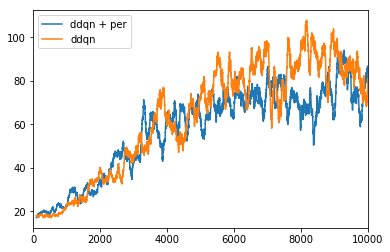

In [14]:
pd.Series(rewards1).rolling(window=100).mean().plot(label='ddqn + per')
pd.Series(rewards2).rolling(window=100).mean().plot(label='ddqn')
plt.legend()
plt.show()

In [15]:
eval_episodes = 200
ave1 = agent1.evaluate(env, eval_episodes)
ave2 = agent2.evaluate(env, eval_episodes)

print('DDQN Average performance = {}'.format(ave2))
print('DDQN + PER Average performance = {}'.format(ave1))

DDQN Average performance = 189.325
DDQN + PER Average performance = 120.145


### References 
[1] Tom Schaul, David Silver et al (2016). Prioritized Experience Replay. https://arxiv.org/abs/1511.05952